In [ ]:
# Install the SQLAlchemy library if it is not installed
!sudo apt-get install python3-dev libmysqlclient-dev > /dev/null
!pip install mysqlclient > /dev/null
!sudo pip3 install -U sql_magic > /dev/null
!pip install psycopg2-binary > /dev/null'

# Google colab upgraded the default SQL Alchemy … this break pandas read_sql
# We are downgrading SQL Alchemy for now.
!pip install -U 'sqlalchemy<2.0'

/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.29
    Uninstalling SQLAlchemy-2.0.29:
      Successfully uninstalled SQLAlchemy-2.0.29
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.52 which is incompatible.


In [ ]:
import pandas as pd
from sqlalchemy import create_engine

In [ ]:
conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='Cocoa',
    password='5xUzs4BPI1g=',
    host = 'jsedocc7.scrc.nyu.edu',
    port     = 3306,
    encoding = 'utf-8',
    db = 'Cocoa'
)
engine = create_engine(conn_string)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sqlalchemy import event

# This is for speeding up the insertion into the database schema
@event.listens_for(engine, 'before_cursor_execute')
def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
    if executemany:
        cursor.fast_executemany = True

In [ ]:
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Training data model

In [ ]:
#movies_train_all = pd.read_csv('rotten_tomatoes_movies.csv')
#movies_train_all.head(3)

In [ ]:
#movies_train_all.columns

In [ ]:
#movies_train = movies_train_all[['movie_title', 'movie_info', 'critics_consensus','content_rating', 'genres', 'runtime','tomatometer_rating','audience_rating']]
#movies_train.head(3)

In [ ]:
#movies_train.shape

In [ ]:
#movies_train.dtypes

In [ ]:
#create_movies_all_table_query = '''
#CREATE TABLE movies_all (
#    movie_title VARCHAR(255),
#    movie_info TEXT,
#    critics_consensus TEXT,
#    content_rating VARCHAR(50),
#    genres VARCHAR(255),
#    runtime INT,
#    tomatometer_rating FLOAT,
#    audience_rating FLOAT
#)
#'''

# Execute the SQL query to create the table
#engine.execute(create_movies_all_table_query)

In [ ]:
#movies_train['critics_consensus'] = movies_train['critics_consensus'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
#movies_train.to_sql('movies_all', engine, if_exists='replace', index=False)

In [ ]:
movies_train = pd.read_sql('SELECT * FROM movies_all', con= engine)
movies_train_all = pd.read_sql('SELECT * FROM movies_all', con= engine)
movies_train_all.head(3)

,movie_title,movie_info,critics_consensus,content_rating,genres,runtime,tomatometer_rating,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",119.0,49.0,53.0
1,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,90.0,87.0,64.0
2,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",122.0,67.0,53.0


In [ ]:
movies_train_all.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'content_rating',
       'genres', 'runtime', 'tomatometer_rating', 'audience_rating'],
      dtype='object')

In [ ]:
movies_train['content_rating'].unique()
#movies_train['genres'].unique()

array(['PG', 'R', 'NR', 'G', 'PG-13', 'NC17'], dtype=object)

In [ ]:
# Create dummy columns for content ratings
content_rating_dummy = pd.get_dummies(pd.Series(movies_train['content_rating']), dtype=int)

# Add dummy columns to the DataFrame using .loc
movies_train.loc[:, content_rating_dummy.columns] = content_rating_dummy

movies_train.head(3)

,movie_title,movie_info,critics_consensus,content_rating,genres,runtime,tomatometer_rating,audience_rating,G,NC17,NR,PG,PG-13,R
0,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",119.0,49.0,53.0,0,0,0,1,0,0
1,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,90.0,87.0,64.0,0,0,0,0,0,1
2,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",122.0,67.0,53.0,0,0,0,0,0,1


In [ ]:
genres_split = movies_train['genres'].str.split(', ')
flattened_genres = genres_split.explode()
flattened_genres.unique()

array(['Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics',
       'Kids & Family', 'Mystery & Suspense', 'Western',
       'Art House & International', 'Horror', 'Faith & Spirituality',
       'Animation', 'Documentary', 'Special Interest',
       'Musical & Performing Arts', 'Sports & Fitness', 'Television',
       'Cult Movies', 'Anime & Manga', 'Gay & Lesbian', None],
      dtype=object)

In [ ]:
unique_genres = ['Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics',
       'Kids & Family', 'Mystery & Suspense', 'Western',
       'Art House & International', 'Horror', 'Faith & Spirituality',
       'Animation', 'Documentary', 'Special Interest',
       'Musical & Performing Arts', 'Sports & Fitness', 'Television',
       'Cult Movies', 'Anime & Manga', 'Gay & Lesbian']

# Convert the list of list genres_split into a DataFrame
genres_df = pd.DataFrame(genres_split, columns=['genres'])

# Replace NaN values with an empty list
genres_df['genres'] = genres_df['genres'].fillna('')

# Initialize an empty DataFrame to store the binary encoding
binary_encoding = pd.DataFrame()

# Iterate over each unique genre
for genre in unique_genres:
    # Check if the genre exists in the 'genres' column
    binary_encoding[genre] = genres_df['genres'].apply(lambda x: 1 if genre.strip() in x else 0)

# Print the binary encoding DataFrame
binary_encoding.head(3)

,Action & Adventure,Comedy,Drama,Science Fiction & Fantasy,Romance,Classics,Kids & Family,Mystery & Suspense,Western,Art House & International,...,Faith & Spirituality,Animation,Documentary,Special Interest,Musical & Performing Arts,Sports & Fitness,Television,Cult Movies,Anime & Manga,Gay & Lesbian
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
binary_encoding.columns.unique()

Index(['Action & Adventure', 'Comedy', 'Drama', 'Science Fiction & Fantasy',
       'Romance', 'Classics', 'Kids & Family', 'Mystery & Suspense', 'Western',
       'Art House & International', 'Horror', 'Faith & Spirituality',
       'Animation', 'Documentary', 'Special Interest',
       'Musical & Performing Arts', 'Sports & Fitness', 'Television',
       'Cult Movies', 'Anime & Manga', 'Gay & Lesbian'],
      dtype='object')

In [ ]:
movies_train.loc[:, unique_genres] = binary_encoding
columns_to_drop = ["genres", "content_rating"]

# Drop the specified columns only if they exist
movies_train = movies_train.drop(columns=columns_to_drop, errors='ignore')

movies_train.rename(columns={"Mystery & Suspense":"Mystery & Thriller"}, inplace=True)
movies_train.rename(columns={"Musical & Performing Arts":"Musical"}, inplace=True)
movies_train.rename(columns={"Sports & Fitness":"Sports"}, inplace=True)
movies_train.rename(columns={"Anime & Manga":"Anime"}, inplace=True)
movies_train.rename(columns={"Gay & Lesbian":"LGBTQ+"}, inplace=True)

movies_train.head(3)

,movie_title,movie_info,critics_consensus,runtime,tomatometer_rating,audience_rating,G,NC17,NR,PG,...,Faith & Spirituality,Animation,Documentary,Special Interest,Musical,Sports,Television,Cult Movies,Anime,LGBTQ+
0,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,119.0,49.0,53.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,90.0,87.0,64.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,122.0,67.0,53.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sentiment Test

In [ ]:
import numpy as np
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Create a sentiment analyzer object
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Replace missing values with empty strings
movies_train['critics_consensus'] = movies_train['critics_consensus'].replace(np.nan, '', regex=True)

# Iterate over the review text column and calculate the sentiment scores
sentiment_scores = []
for text in movies_train['critics_consensus']:
    scores = sid.polarity_scores(text)
    sentiment_scores.append(scores['compound'])

# Add the sentiment scores as a new column in the DataFrame
movies_train['Sentiment Score'] = sentiment_scores

# Define a function to map the compound scores to sentiment labels
def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the get_sentiment_label function to the sentiment scores to get the sentiment labels
sentiment_labels = movies_train['Sentiment Score'].apply(get_sentiment_label)
# Add the sentiment labels as a new column in the DataFrame
movies_train['Sentiment Label'] = sentiment_labels

# Count the number of reviews for each sentiment label
sentiment_counts = movies_train['Sentiment Label'].value_counts()

movies_train.head(3)

,movie_title,movie_info,critics_consensus,runtime,tomatometer_rating,audience_rating,G,NC17,NR,PG,...,Documentary,Special Interest,Musical,Sports,Television,Cult Movies,Anime,LGBTQ+,Sentiment Score,Sentiment Label
0,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,119.0,49.0,53.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.9274,Positive
1,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,90.0,87.0,64.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.5023,Positive
2,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,122.0,67.0,53.0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.4676,Negative


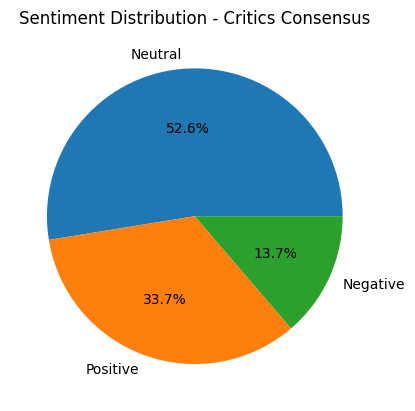

In [ ]:
# Create a pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution - Critics Consensus')
plt.show()

Visualization

<Axes: xlabel='tomatometer_rating', ylabel='audience_rating'>

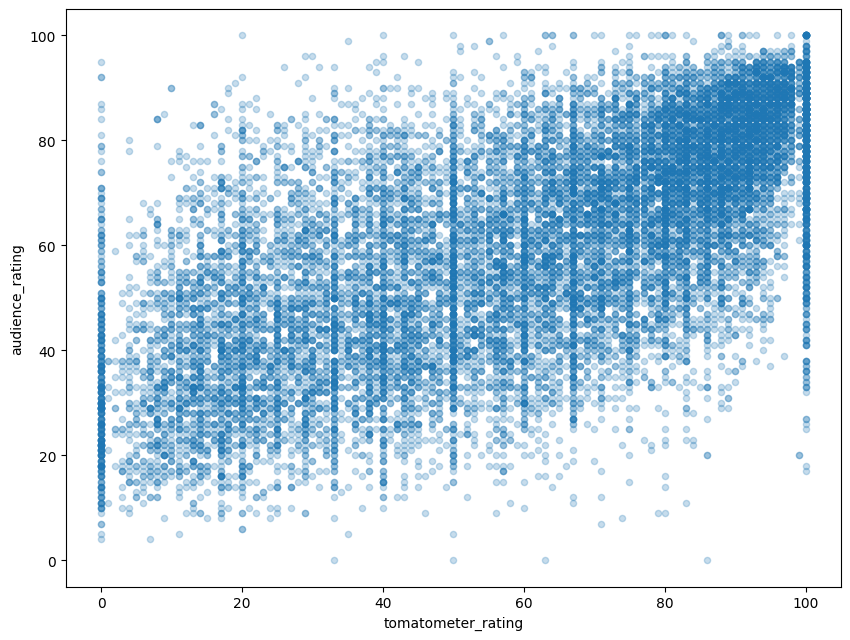

In [ ]:
# Scatterplot (tomatometer_rating vs. audience_rating)
movies_train.plot (
    kind='scatter',
    x = 'tomatometer_rating',
    y = 'audience_rating',
    figsize = (10, 7.5),
    alpha = 0.25
)

<Axes: xlabel='tomatometer_rating', ylabel='audience_rating'>

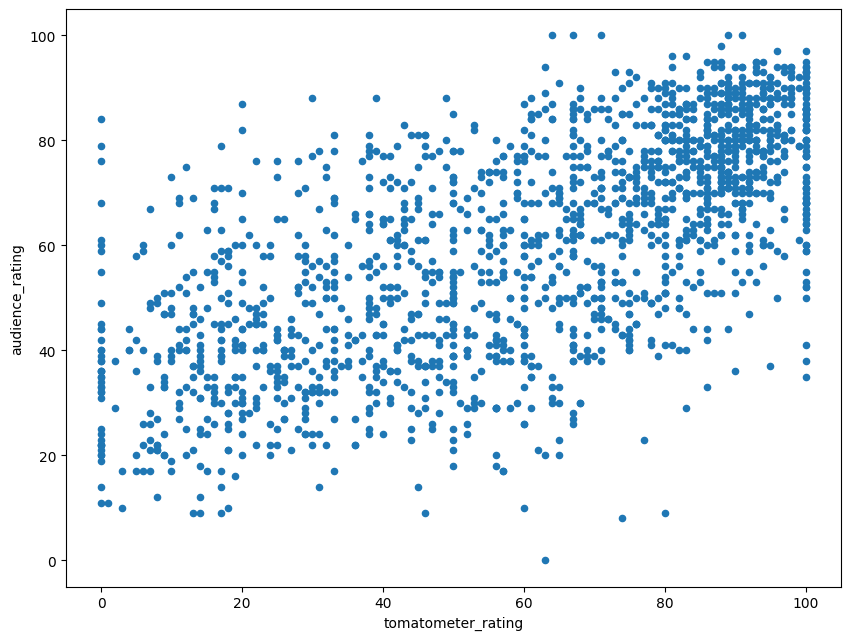

In [ ]:
sample = movies_train.sample(frac=0.1)

sample.plot (
    kind='scatter',
    x = 'tomatometer_rating',
    y = 'audience_rating',
    figsize = (10,7.5)
)

<Axes: title={'center': 'tomatometer_rating'}, xlabel='content_rating'>

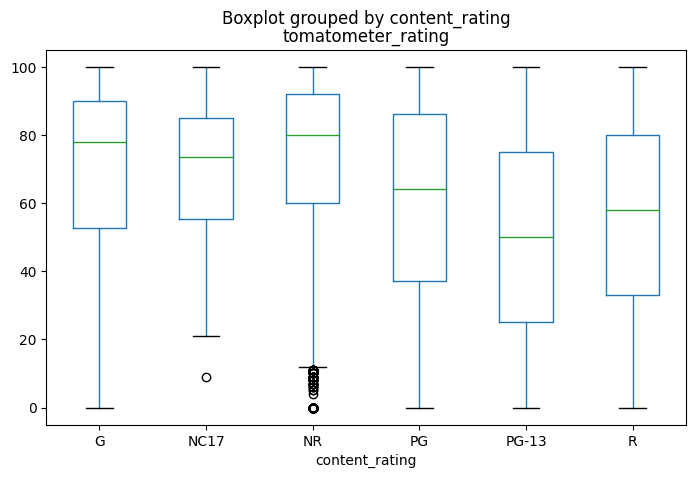

In [ ]:
movies_train_all.boxplot(column='tomatometer_rating', by='content_rating', grid=False, figsize = (8,5))

<Axes: title={'center': 'audience_rating'}, xlabel='content_rating'>

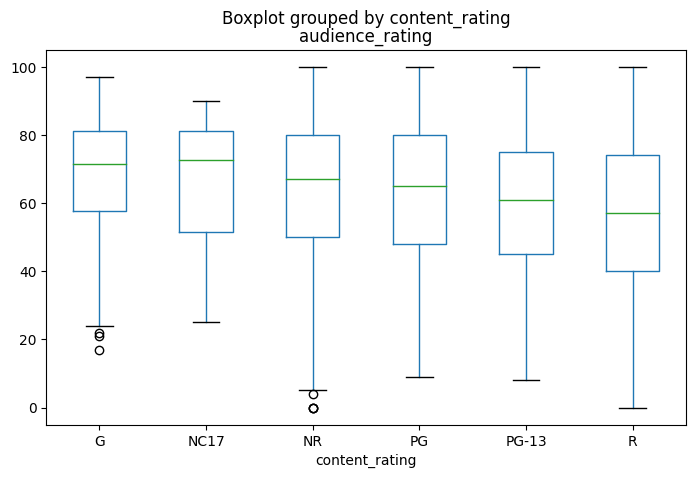

In [ ]:
movies_train_all.boxplot(column='audience_rating', by='content_rating', grid=False, figsize = (8,5))

In [ ]:
joined_df = flattened_genres.to_frame().join(movies_train[['tomatometer_rating', 'audience_rating']])

# Fill missing values with corresponding values from movies_train[['tomatometer_rating', 'audience_rating']]
joined_df['tomatometer_rating'] = joined_df['tomatometer_rating'].fillna(movies_train['tomatometer_rating'])
joined_df['audience_rating'] = joined_df['audience_rating'].fillna(movies_train['audience_rating'])
joined_df.reset_index(drop=True, inplace=True)
# Print the joined DataFrame
joined_df.head(3)

,genres,tomatometer_rating,audience_rating
0,Action & Adventure,49.0,53.0
1,Comedy,49.0,53.0
2,Drama,49.0,53.0


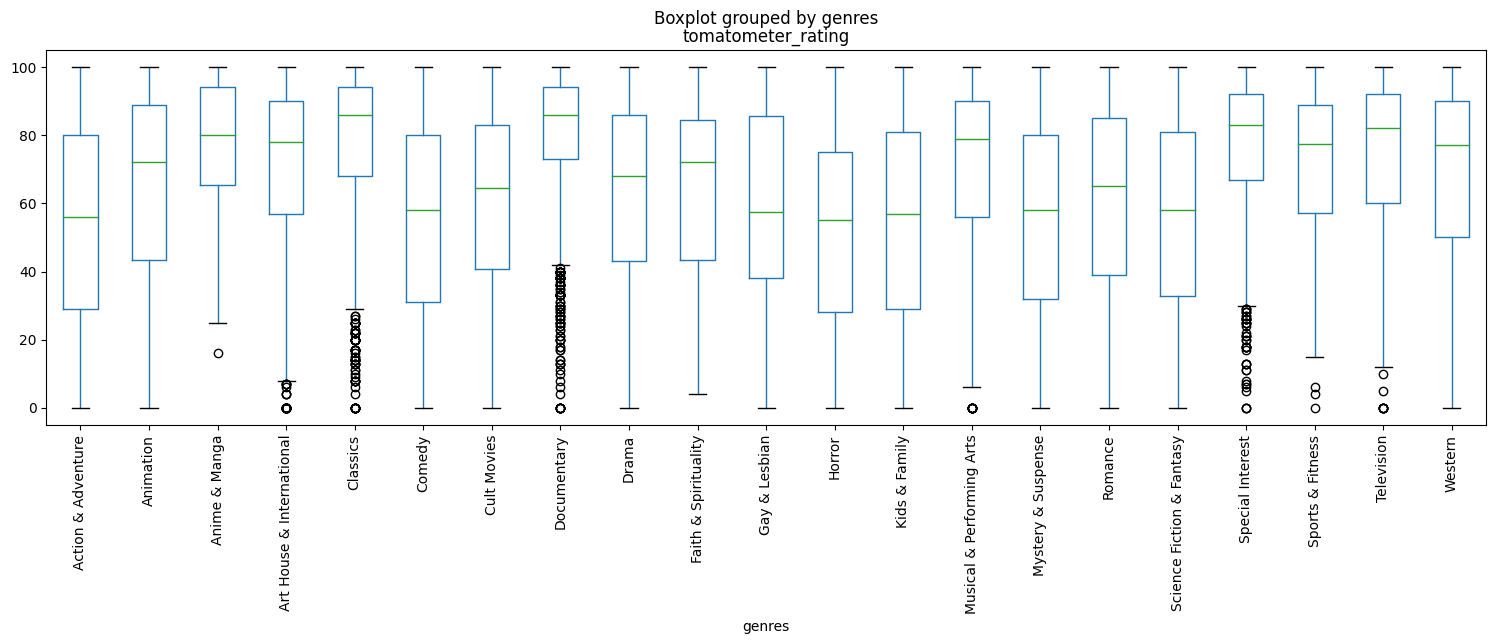

In [ ]:
import matplotlib.pyplot as plt
ax = joined_df.boxplot(column='tomatometer_rating', by='genres', grid=False, figsize = (18,5))
plt.xticks(rotation=90)
plt.show()

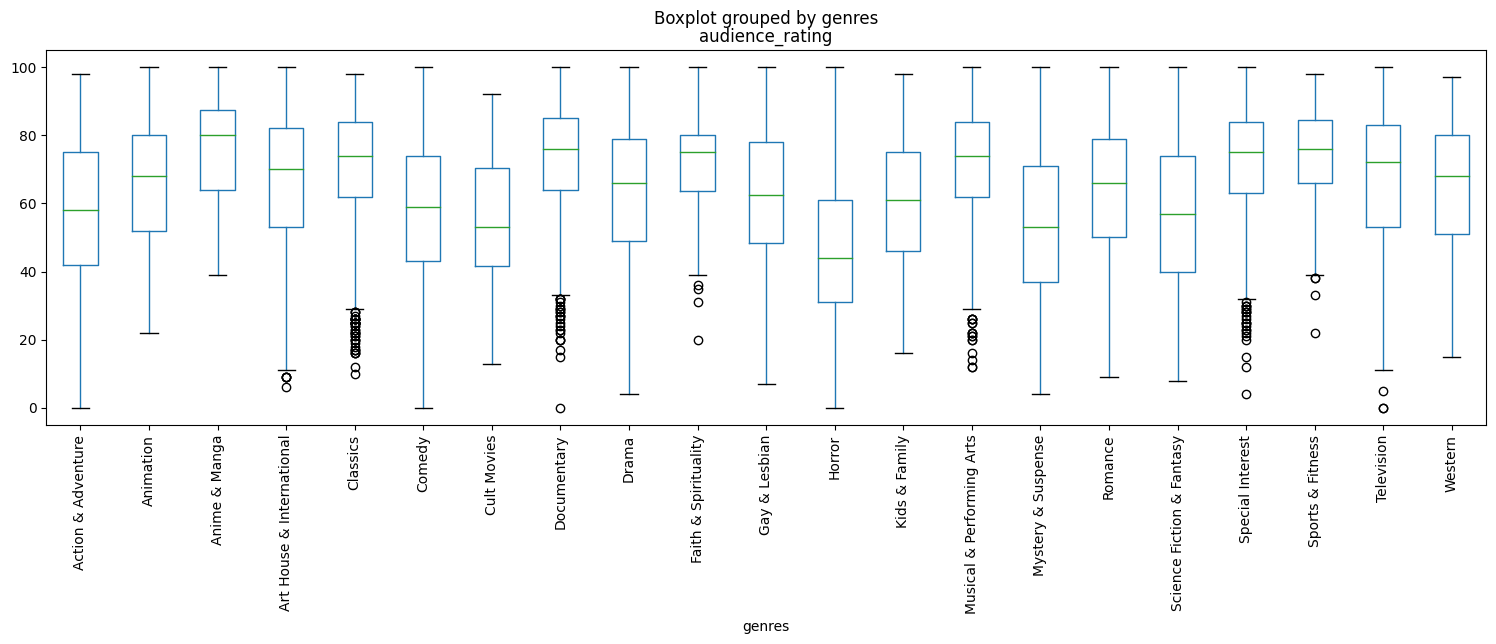

In [ ]:
ax = joined_df.boxplot(column='audience_rating', by='genres', grid=False, figsize = (18,5))
plt.xticks(rotation=90)
plt.show()

Regression

In [ ]:
movies_train.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'runtime',
       'tomatometer_rating', 'audience_rating', 'G', 'NC17', 'NR', 'PG',
       'PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+',
       'Sentiment Score', 'Sentiment Label'],
      dtype='object')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt

#Regression 1: predict tomatometer rating

# Fill NaN values with zeros
X_t = movies_train[['runtime', 'Sentiment Score', 'audience_rating',
       'G', 'NC17', 'NR', 'PG','PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+']].fillna(0)

y_t = movies_train['tomatometer_rating'].fillna(0)

# Initialize and fit the Linear Regression model
lr_t = LinearRegression()
lr_t.fit(X_t, y_t)

# Coefficients and intercept of the model
print('Coefficients:', lr_t.coef_)
print('Intercept:', lr_t.intercept_)

Coefficients: [ -0.04024624  12.02335011   0.68332187   2.00838944   3.19523651
   8.20274841  -2.29216856  -9.01548061  -2.09872519  -3.03705053
  -2.69017437   2.54926729   0.69531899  -2.30850753   9.00243475
  -4.72674718   0.5376191    4.14697621   4.68898946   2.34379607
 -11.05301858   2.48971999  12.89309983  -2.32713815  -2.04022685
  -5.21088335   2.22246996   2.40100746   1.74365968  -6.05651893]
Intercept: 19.775160316076374


In [ ]:
regression1 = pd.DataFrame([("intercept", lr_t.intercept_)] + list(zip(movies_train.columns[:-1], lr_t.coef_)), columns = ["feature_betas", "coefficients"])
display(regression1)

,feature_betas,coefficients
0,intercept,19.775160
1,movie_title,-0.040246
2,movie_info,12.023350
3,critics_consensus,0.683322
4,runtime,2.008389
5,tomatometer_rating,3.195237
6,audience_rating,8.202748
7,G,-2.292169
8,NC17,-9.015481
9,NR,-2.098725


In [ ]:
X_t = movies_train[['runtime', 'Sentiment Score', 'audience_rating',
       'G', 'NC17', 'NR', 'PG','PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+']].fillna(0)
y_t = movies_train['tomatometer_rating'].fillna(0)

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

# Fit the model with scikit-learn
lr_t = LinearRegression()
lr_t.fit(X_train_t, y_train_t)

# Predict on the test data
y_pred_t = lr_t.predict(X_test_t)

# Print out metrics
print('Mean squared error (MSE):', mean_squared_error(y_test_t, y_pred_t))
print('Coefficient of determination (R^2):', r2_score(y_test_t, y_pred_t))

Mean squared error (MSE): 415.3868343835202
Coefficient of determination (R^2): 0.4918259624460448


In [ ]:
# Fit the model with statsmodels
X_train_t_sm = sm.add_constant(X_train_t)  # adding a constant
lr_t_sm = sm.OLS(y_train_t, X_train_t_sm).fit()

# Print out the statistics
print(lr_t_sm.summary())

                            OLS Regression Results                            
Dep. Variable:     tomatometer_rating   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     453.6
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        16:13:03   Log-Likelihood:                -62940.
No. Observations:               14169   AIC:                         1.259e+05
Df Residuals:                   14139   BIC:                         1.262e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Since the variables that have a relatively high p-value are dummy variables, I won't remove anything from the model.

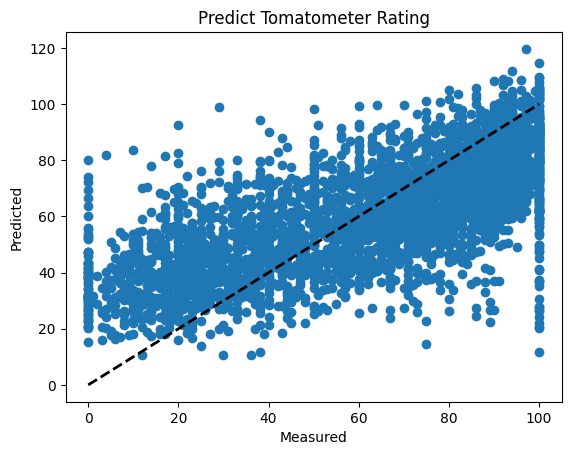

In [ ]:
# Plotting
plt.scatter(y_test_t, y_pred_t)
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predict Tomatometer Rating')
plt.show()

In [ ]:
#Regression 2: predict audience rating

# Fill NaN values with zeros
X_a = movies_train[['runtime', 'Sentiment Score', 'tomatometer_rating',
       'G', 'NC17', 'NR', 'PG','PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+']].fillna(0)

y_a = movies_train['audience_rating'].fillna(0)

# Initialize and fit the Linear Regression model
lr_a = LinearRegression()
lr_a.fit(X_a, y_a)

# Coefficients and intercept of the model
print('Coefficients:', lr_a.coef_)
print('Intercept:', lr_a.intercept_)

Coefficients: [ 0.15272185  1.29904755  0.4246995   0.0299091   1.96342295 -5.09720389
  1.13338145  2.81461456 -0.84412418 -0.09415087  0.20025657  2.3916303
 -0.79419017  0.99981643  4.77003311  0.59748392 -2.51034442 -0.99794888
  2.66507868 -6.05666246  5.33826971  6.55176716  3.54540164  3.8828568
  3.60374094  5.5829169   2.28352051 -0.65898742  3.65227029  3.14346867]
Intercept: 17.247273795113536


In [ ]:
regression2 = pd.DataFrame([("intercept", lr_a.intercept_)] + list(zip(movies_train.columns[:-1], lr_a.coef_)), columns = ["feature_betas", "coefficients"])
display(regression2)

,feature_betas,coefficients
0,intercept,17.247274
1,movie_title,0.152722
2,movie_info,1.299048
3,critics_consensus,0.424700
4,runtime,0.029909
5,tomatometer_rating,1.963423
6,audience_rating,-5.097204
7,G,1.133381
8,NC17,2.814615
9,NR,-0.844124


In [ ]:
X_a = movies_train[['runtime', 'Sentiment Score', 'tomatometer_rating',
       'G', 'NC17', 'NR', 'PG','PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+']].fillna(0)
y_a = movies_train['audience_rating'].fillna(0)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

# Fit the model with scikit-learn
lr_a = LinearRegression()
lr_a.fit(X_train_a, y_train_a)

# Predict on the test data
y_pred_a = lr_a.predict(X_test_a)

# Print out metrics
print('Mean squared error (MSE):', mean_squared_error(y_test_a, y_pred_a))
print('Coefficient of determination (R^2):', r2_score(y_test_a, y_pred_a))

Mean squared error (MSE): 257.6715506930499
Coefficient of determination (R^2): 0.45005737595777895


In [ ]:
# Fit the model with statsmodels
X_train_a_sm = sm.add_constant(X_train_a)  # adding a constant
lr_a_sm = sm.OLS(y_train_a, X_train_a_sm).fit()

# Print out the statistics
print(lr_a_sm.summary())

                            OLS Regression Results                            
Dep. Variable:        audience_rating   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     397.3
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        16:13:05   Log-Likelihood:                -59573.
No. Observations:               14169   AIC:                         1.192e+05
Df Residuals:                   14139   BIC:                         1.194e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

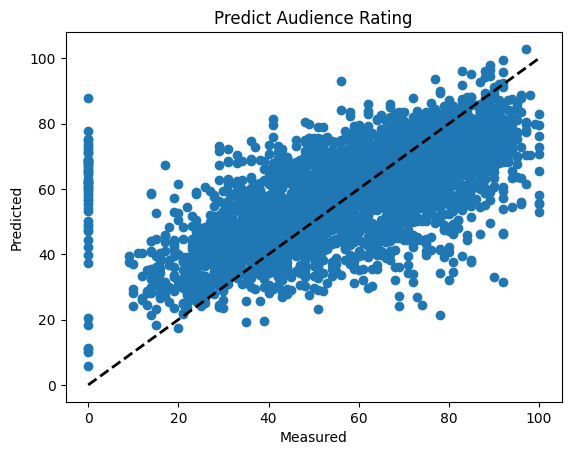

In [ ]:
# Plotting
plt.scatter(y_test_a, y_pred_a)
plt.plot([y_a.min(), y_a.max()], [y_a.min(), y_a.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predict Audience Rating')
plt.show()

In [ ]:
#Regression 3: predict tomatometer_rating without knowing audience_rating

# Fill NaN values with zeros
X_tna = movies_train[['runtime', 'Sentiment Score',
       'G', 'NC17', 'NR', 'PG','PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+']].fillna(0)

y_tna = movies_train['tomatometer_rating'].fillna(0)

# Initialize and fit the Linear Regression model
lr_tna = LinearRegression()
lr_tna.fit(X_tna, y_tna)

# Coefficients and intercept of the model
print('Coefficients:', lr_tna.coef_)
print('Intercept:', lr_tna.intercept_)

Coefficients: [  0.09032477  18.18982138   2.85833397   6.39183947   6.64942299
  -2.13823335  -9.99190963  -3.76945345  -4.36941969  -3.59729207
   5.89399643   0.21503644  -2.28983641  17.27530898  -6.08412602
  -1.65929116   4.88178001   9.17181638  -2.52869852 -10.43298043
   9.81508765  21.57775389   0.45943336   0.59494507  -1.96670444
   5.32950676   2.74827373   5.97263236  -5.50655621]
Intercept: 44.4644787359363


In [ ]:
regression3 = pd.DataFrame([("intercept", lr_tna.intercept_)] + list(zip(movies_train.columns[:-1], lr_tna.coef_)), columns = ["feature_betas", "coefficients"])
display(regression3)

,feature_betas,coefficients
0,intercept,44.464479
1,movie_title,0.090325
2,movie_info,18.189821
3,critics_consensus,2.858334
4,runtime,6.391839
5,tomatometer_rating,6.649423
6,audience_rating,-2.138233
7,G,-9.991910
8,NC17,-3.769453
9,NR,-4.369420


In [ ]:
X_tna = movies_train[['runtime', 'Sentiment Score',
       'G', 'NC17', 'NR', 'PG','PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+']].fillna(0)
y_tna = movies_train['tomatometer_rating'].fillna(0)

X_train_tna, X_test_tna, y_train_tna, y_test_tna = train_test_split(X_tna, y_tna, test_size=0.2, random_state=42)

# Fit the model with scikit-learn
lr_tna = LinearRegression()
lr_tna.fit(X_train_tna, y_train_tna)

# Predict on the test data
y_pred_tna = lr_tna.predict(X_test_tna)

# Print out metrics
print('Mean squared error (MSE):', mean_squared_error(y_test_tna, y_pred_tna))
print('Coefficient of determination (R^2):', r2_score(y_test_tna, y_pred_tna))

Mean squared error (MSE): 579.8975389616071
Coefficient of determination (R^2): 0.2905676122858524


In [ ]:
# Fit the model with statsmodels
X_train_tna_sm = sm.add_constant(X_train_tna)  # adding a constant
lr_tna_sm = sm.OLS(y_train_tna, X_train_tna_sm).fit()

# Print out the statistics
print(lr_tna_sm.summary())

                            OLS Regression Results                            
Dep. Variable:     tomatometer_rating   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     185.3
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        16:13:06   Log-Likelihood:                -65385.
No. Observations:               14169   AIC:                         1.308e+05
Df Residuals:                   14140   BIC:                         1.310e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

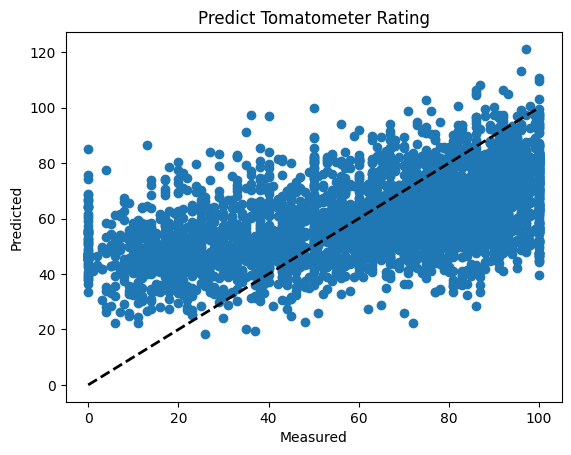

In [ ]:
# Plotting
plt.scatter(y_test_tna, y_pred_tna)
plt.plot([y_tna.min(), y_tna.max()], [y_tna.min(), y_tna.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predict Tomatometer Rating')
plt.show()

In [ ]:
#Regression 4: predict audience_rating without knowing tomatometer_rating

# Fill NaN values with zeros
X_ant = movies_train[['runtime', 'Sentiment Score',
       'G', 'NC17', 'NR', 'PG','PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+']].fillna(0)

y_ant = movies_train['audience_rating'].fillna(0)

# Initialize and fit the Linear Regression model
lr_ant = LinearRegression()
lr_ant.fit(X_ant, y_ant)

# Coefficients and intercept of the model
print('Coefficients:', lr_ant.coef_)
print('Intercept:', lr_ant.intercept_)

Coefficients: [ 0.19108273  9.02425562  1.24384211  4.67803399 -2.27319726  0.22527481
 -1.42894447 -2.44500918 -1.94984123 -1.32751157  4.89480765 -0.7028643
  0.02732405 12.10684823 -1.98644137 -3.21504455  1.07534066  6.56034452
 -7.13059946  0.90738813 10.72022999 12.70946296  4.07797792  3.85641381
  4.74765851  4.54695937  0.50820306  6.18884428  0.80483699]
Intercept: 36.13131575465581


In [ ]:
regression4 = pd.DataFrame([("intercept", lr_ant.intercept_)] + list(zip(movies_train.columns[:-1], lr_ant.coef_)), columns = ["feature_betas", "coefficients"])
display(regression4)

,feature_betas,coefficients
0,intercept,36.131316
1,movie_title,0.191083
2,movie_info,9.024256
3,critics_consensus,1.243842
4,runtime,4.678034
5,tomatometer_rating,-2.273197
6,audience_rating,0.225275
7,G,-1.428944
8,NC17,-2.445009
9,NR,-1.949841


In [ ]:
X_ant = movies_train[['runtime', 'Sentiment Score',
       'G', 'NC17', 'NR', 'PG','PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+']].fillna(0)
y_ant = movies_train['audience_rating'].fillna(0)

X_train_ant, X_test_ant, y_train_ant, y_test_ant = train_test_split(X_ant, y_ant, test_size=0.2, random_state=42)

# Fit the model with scikit-learn
lr_ant = LinearRegression()
lr_ant.fit(X_train_ant, y_train_ant)

# Predict on the test data
y_pred_ant = lr_ant.predict(X_test_ant)

# Print out metrics
print('Mean squared error (MSE):', mean_squared_error(y_test_ant, y_pred_ant))
print('Coefficient of determination (R^2):', r2_score(y_test_ant, y_pred_ant))

Mean squared error (MSE): 359.7108637934835
Coefficient of determination (R^2): 0.2322771536127598


In [ ]:
# Fit the model with statsmodels
X_train_ant_sm = sm.add_constant(X_train_ant)  # adding a constant
lr_tna_sm = sm.OLS(y_train_ant, X_train_ant_sm).fit()

# Print out the statistics
print(lr_tna_sm.summary())

                            OLS Regression Results                            
Dep. Variable:        audience_rating   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     144.1
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        16:13:07   Log-Likelihood:                -62018.
No. Observations:               14169   AIC:                         1.241e+05
Df Residuals:                   14140   BIC:                         1.243e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

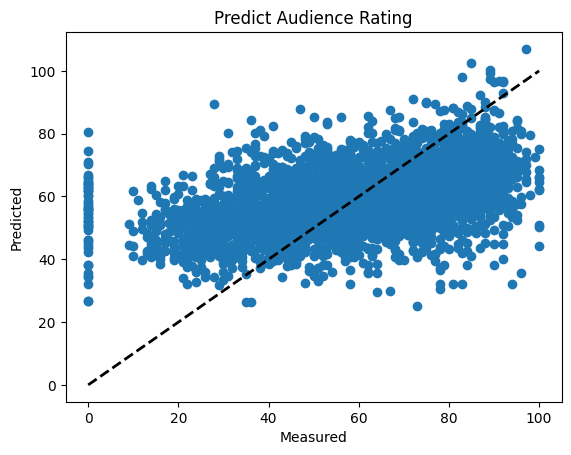

In [ ]:
# Plotting
plt.scatter(y_test_ant, y_pred_ant)
plt.plot([y_ant.min(), y_ant.max()], [y_ant.min(), y_ant.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predict Audience Rating')
plt.show()

In-theater data from web scraping


In [ ]:
import requests
from bs4 import BeautifulSoup

url_load = "https://www.rottentomatoes.com/browse/movies_in_theaters/sort:popular?page=1"
resp = requests.get(url_load)
soup = BeautifulSoup(resp.text, 'html.parser')

In [ ]:
#Rotten Tomatoes Movies in Theaters + total page num = 5, thus all in-theater movie data By Sherry
import pandas as pd
import requests
from bs4 import BeautifulSoup

def get_in_theater(page_num):
  movie_dict = {'movie_title':[], 'release_date': [], 'tomatometer_rating':[], 'audience_rating': [], 'image': [], 'link': []}
  url_load = "https://www.rottentomatoes.com/browse/movies_in_theaters/sort:popular?page="+page_num
  resp = requests.get(url_load)
  soup = BeautifulSoup(resp.text, 'html.parser')

  url_title = []

  for tag in soup.find_all('tile-dynamic', {'isvideo': 'true'}):
  #for tag in soup.find_all('a', {'data-track': 'scores'}):
     name = tag.find('span', {'data-qa': 'discovery-media-list-item-title'}).text
     date = tag.find('span', {'data-qa': 'discovery-media-list-item-start-date'}).text
     audience_score = tag.find('score-pairs-deprecated')['audiencescore']
     critic_score = tag.find('score-pairs-deprecated')['criticsscore']
     image = tag.find('rt-img')['src']
     link = tag.find('a', {'data-track': 'scores'})['href']
     movie_dict['movie_title'].append(name.strip())
     movie_dict['release_date'].append(date.strip())
     movie_dict['tomatometer_rating'].append(critic_score.strip())
     movie_dict['audience_rating'].append(audience_score.strip())
     movie_dict['image'].append(image.strip())
     movie_dict['link'].append("https://www.rottentomatoes.com"+link.strip())

     url_title.append("https://www.rottentomatoes.com" + link.strip())

  return pd.DataFrame(movie_dict), url_title

df1, url_title = get_in_theater('10')
#styled_df1 = df1.style.set_properties(subset=df1.columns[0],**{'text-align': 'left'})
#display(styled_df1)
#Top 10
df1.head(10)

,movie_title,release_date,tomatometer_rating,audience_rating,image,link
0,The Fall Guy,"Opened May 03, 2024",83,87,https://resizing.flixster.com/X-k7-qm7k0NOJO2N...,https://www.rottentomatoes.com/m/the_fall_guy_...
1,Challengers,"Opened Apr 26, 2024",89,74,https://resizing.flixster.com/dMJO96IcJPA2EBIn...,https://www.rottentomatoes.com/m/challengers_2024
2,Unfrosted,"Opened May 03, 2024",40,49,https://resizing.flixster.com/T4s5r7Dc85R3yDbD...,https://www.rottentomatoes.com/m/unfrosted
3,The Idea of You,"Opened May 02, 2024",83,,https://resizing.flixster.com/Alqr64OHCup6sgVd...,https://www.rottentomatoes.com/m/the_idea_of_you
4,Civil War,"Opened Apr 12, 2024",81,71,https://resizing.flixster.com/NQBQ5LgZ81RozsQX...,https://www.rottentomatoes.com/m/civil_war_2024
5,Late Night with the Devil,"Opened Mar 22, 2024",97,81,https://resizing.flixster.com/4f0eZnLWyqd8Nnve...,https://www.rottentomatoes.com/m/late_night_wi...
6,Tarot,"Opened May 03, 2024",12,58,https://resizing.flixster.com/yFF-y5yZ6-7Wv6d5...,https://www.rottentomatoes.com/m/tarot_2024
7,Monkey Man,"Opened Apr 05, 2024",89,84,https://resizing.flixster.com/QeRvdQUUQLc3lHba...,https://www.rottentomatoes.com/m/monkey_man
8,I Saw the TV Glow,"Opened May 03, 2024",88,,https://resizing.flixster.com/kuWkEWQilgtljWHK...,https://www.rottentomatoes.com/m/i_saw_the_tv_...
9,Abigail,"Opened Apr 19, 2024",84,85,https://resizing.flixster.com/1BLUnSuUK_dXry4S...,https://www.rottentomatoes.com/m/abigail_2024


In [ ]:
import requests
from bs4 import BeautifulSoup

url_load = "https://www.rottentomatoes.com/m/arcadian"
resp = requests.get(url_load)
soup = BeautifulSoup(resp.text, 'html.parser')

In [ ]:
duration_text = soup.find('rt-text', {'slot': 'duration'}).text

# Split the duration_text into hours and minutes
parts = duration_text.split()

# Initialize hours and minutes
hours = 0
minutes = 0

# Iterate through the parts to find hours and minutes
for i in range(len(parts)):
    if 'hr.' in parts[i]:
        hours = int(parts[i-1])
    elif 'min.' in parts[i]:
        minutes = int(parts[i-1])

# Calculate total duration in minutes
runtime = hours * 60 + minutes

print("Duration in minutes:", runtime)

Duration in minutes: 0


In [ ]:
genre_elements = soup.find_all('rt-text', {'slot': 'genre'})

# Extract text content from each element
genres = [genre.text for genre in genre_elements]

# Convert the list of genres into a DataFrame
print(genres)

['Horror', 'Action', 'Mystery & Thriller']


In [ ]:
#soup.find('rt-text', {'size': '1.25, 1.75'}).text #name
#soup.find('rt-text', {'slot': 'ratingsCode'}).text #rating
#soup.find('rt-text', {'slot': 'duration'}).text #runtime
#soup.find_all('rt-text', {'slot': 'genre'}) #genres
#soup.find('rt-text', {'slot': 'content'}).text #movie_info
#soup.find('div', {'id': 'critics-consensus'}).find('p').text #critics_consensus
soup.find('where-to-watch-meta')['href']

'https://www.vudu.com/content/browse/details/Arcadian/3147142?cmp=rt_where_to_watch'

In [ ]:
def get_movie_des(title):
    des_dict = {'movie_title':[], 'runtime':[], 'genres': [], 'content_rating':[], 'critics_consensus': [], 'movie_info': [],'theater_link':[]}
    url_des = title
    resp = requests.get(url_des)
    soup = BeautifulSoup(resp.text, 'html.parser')

    for tag in soup.find_all('div', {'id': 'main-page-content'}):
        name = tag.find('rt-text', {'size': '1.25, 1.75'}).text
        genre_elements = soup.find_all('rt-text', {'slot': 'genre'})

        # Extract text content from each element and join them into a single string separated by commas
        genres = ', '.join([genre.text for genre in genre_elements])

        info = tag.find('rt-text', {'slot': 'content'}).text

        rating = None
        duration = None
        consensus = None
        t_link = None
        try:
            rating = tag.find('rt-text', {'slot': 'ratingsCode'}).text
            duration_text = soup.find('rt-text', {'slot': 'duration'}).text

            # Split the duration_text into hours and minutes
            parts = duration_text.split()

            # Initialize hours and minutes
            hours = 0
            minutes = 0

            # Iterate through the parts to find hours and minutes
            for i in range(len(parts)):
                if 'hr.' in parts[i]:
                    hours = int(parts[i-1])
                elif 'min.' in parts[i]:
                    minutes = int(parts[i-1])

            # Calculate total duration in minutes
            runtime = hours * 60 + minutes
            consensus = tag.find('div', {'id': 'critics-consensus'}).find('p').text
            t_link = tag.find('where-to-watch-meta')['href']
        except:
            rating = ""
            runtime = ""
            consensus = ""
            t_link = ""

        des_dict['movie_title'].append(name.strip())
        des_dict['runtime'].append(runtime)
        des_dict['genres'].append(genres)  # Append genres as a single string
        des_dict['content_rating'].append(rating.strip())
        des_dict['critics_consensus'].append(consensus.strip())
        des_dict['movie_info'].append(info.strip())
        des_dict['theater_link'].append(t_link.strip())

    return pd.DataFrame(des_dict)

dfs = []

for title in url_title:
    df2 = pd.DataFrame(get_movie_des(title))
    dfs.append(df2)

result_df = pd.concat(dfs, axis=0)
result_df.reset_index(drop=True, inplace=True)
result_df.head(3)

,movie_title,runtime,genres,content_rating,critics_consensus,movie_info,theater_link
0,The Fall Guy,0,"Action, Comedy, Drama",PG-13,"With action, comedy, romance, and a pair of ma...","He's a stuntman, and like everyone in the stun...",https://www.fandango.com/the-fall-guy-2024-234...
1,Challengers,,Drama,,,"From visionary filmmaker Luca Guadagnino, Chal...",
2,Unfrosted,0,Comedy,PG-13,Much like a preservative-packed toaster pastry...,"Michigan, 1963. Kellogg's and Post, sworn cere...",https://www.netflix.com/watch/81481606?cmp=rt_...


In [ ]:
movies_new = pd.merge(result_df, df1, on="movie_title", how="inner")
movies_predict = movies_new
# Reset index
movies_new.reset_index(drop=True, inplace=True)
movies_new.head(3)

,movie_title,runtime,genres,content_rating,critics_consensus,movie_info,theater_link,release_date,tomatometer_rating,audience_rating,image,link
0,The Fall Guy,0,"Action, Comedy, Drama",PG-13,"With action, comedy, romance, and a pair of ma...","He's a stuntman, and like everyone in the stun...",https://www.fandango.com/the-fall-guy-2024-234...,"Opened May 03, 2024",83,87,https://resizing.flixster.com/X-k7-qm7k0NOJO2N...,https://www.rottentomatoes.com/m/the_fall_guy_...
1,Challengers,,Drama,,,"From visionary filmmaker Luca Guadagnino, Chal...",,"Opened Apr 26, 2024",89,74,https://resizing.flixster.com/dMJO96IcJPA2EBIn...,https://www.rottentomatoes.com/m/challengers_2024
2,Unfrosted,0,Comedy,PG-13,Much like a preservative-packed toaster pastry...,"Michigan, 1963. Kellogg's and Post, sworn cere...",https://www.netflix.com/watch/81481606?cmp=rt_...,"Opened May 03, 2024",40,49,https://resizing.flixster.com/T4s5r7Dc85R3yDbD...,https://www.rottentomatoes.com/m/unfrosted


In [ ]:
movies_predict['content_rating'].unique()

array(['PG-13', '', 'R', 'PG'], dtype=object)

In [ ]:
unique_rating = ['G', 'NC17',	'NR',	'PG',	'PG-13', 'R']

# Create dummy columns for content ratings
content_rating_dummy = pd.get_dummies(pd.Series(movies_predict['content_rating']), dtype=int)
content_rating_dummy.drop('', axis=1, inplace=True)

# Add dummy columns to the DataFrame using .loc
movies_predict.loc[:, unique_rating] = content_rating_dummy
movies_predict[['G', 'NC17', 'NR']] = movies_predict[['G', 'NC17', 'NR']].fillna(0).astype(int)

movies_predict.head(3)

,movie_title,runtime,genres,content_rating,critics_consensus,movie_info,theater_link,release_date,tomatometer_rating,audience_rating,image,link,G,NC17,NR,PG,PG-13,R
0,The Fall Guy,0,"Action, Comedy, Drama",PG-13,"With action, comedy, romance, and a pair of ma...","He's a stuntman, and like everyone in the stun...",https://www.fandango.com/the-fall-guy-2024-234...,"Opened May 03, 2024",83,87,https://resizing.flixster.com/X-k7-qm7k0NOJO2N...,https://www.rottentomatoes.com/m/the_fall_guy_...,0,0,0,0,1,0
1,Challengers,,Drama,,,"From visionary filmmaker Luca Guadagnino, Chal...",,"Opened Apr 26, 2024",89,74,https://resizing.flixster.com/dMJO96IcJPA2EBIn...,https://www.rottentomatoes.com/m/challengers_2024,0,0,0,0,0,0
2,Unfrosted,0,Comedy,PG-13,Much like a preservative-packed toaster pastry...,"Michigan, 1963. Kellogg's and Post, sworn cere...",https://www.netflix.com/watch/81481606?cmp=rt_...,"Opened May 03, 2024",40,49,https://resizing.flixster.com/T4s5r7Dc85R3yDbD...,https://www.rottentomatoes.com/m/unfrosted,0,0,0,0,1,0


In [ ]:
genres_split = movies_new['genres'].str.split(', ')
flattened_genres_new = genres_split.explode()
flattened_genres_new.unique()
#unique_genres = ['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Fantasy',
       #'Romance', 'Kids & Family', 'Mystery & Thriller', 'Horror',
       #'Faith & Spirituality', 'Animation', 'Documentary', 'Musical', 'Sports',
       #'Anime', 'LGBTQ+', 'Music', 'History', 'Biography', 'Crime', 'War']

array(['Action', 'Comedy', 'Drama', 'Romance', 'Mystery & Thriller',
       'Horror', 'Sci-Fi', 'Adventure', 'Music', 'Fantasy', 'History',
       'Kids & Family', 'Animation', 'Biography', 'LGBTQ+', 'Anime',
       'Documentary', 'Crime', 'Musical'], dtype=object)

In [ ]:
unique_genres = ['Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+']

# Convert the list of list genres_split into a DataFrame
genres_df = pd.DataFrame(genres_split, columns=['genres'])

# Replace NaN values with an empty list
genres_df['genres'] = genres_df['genres'].fillna(0)

# Initialize an empty DataFrame to store the binary encoding
binary_encoding2 = pd.DataFrame()

# Iterate over each unique genre
for genre in unique_genres:
    # Check if the genre exists in the 'genres' column
    if genre == 'Action & Adventure':
        binary_encoding2[genre] = (genres_df['genres'].apply(lambda x: 1 if 'Action' in x or 'Adventure' in x else 0))
    elif genre == 'Science Fiction & Fantasy':
        binary_encoding2[genre] = (genres_df['genres'].apply(lambda x: 1 if 'Sci-Fi' in x or 'Fantasy' in x else 0))
    else:
        binary_encoding2[genre] = genres_df['genres'].apply(lambda x: 1 if genre.strip() in x else 0)


# Print the binary encoding DataFrame
binary_encoding2.head(3)

,Action & Adventure,Comedy,Drama,Science Fiction & Fantasy,Romance,Classics,Kids & Family,Mystery & Thriller,Western,Art House & International,...,Faith & Spirituality,Animation,Documentary,Special Interest,Musical,Sports,Television,Cult Movies,Anime,LGBTQ+
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movies_predict.loc[:, unique_genres] = binary_encoding2
movies_predict.head(3)

,movie_title,runtime,genres,content_rating,critics_consensus,movie_info,theater_link,release_date,tomatometer_rating,audience_rating,...,Faith & Spirituality,Animation,Documentary,Special Interest,Musical,Sports,Television,Cult Movies,Anime,LGBTQ+
0,The Fall Guy,0,"Action, Comedy, Drama",PG-13,"With action, comedy, romance, and a pair of ma...","He's a stuntman, and like everyone in the stun...",https://www.fandango.com/the-fall-guy-2024-234...,"Opened May 03, 2024",83,87,...,0,0,0,0,0,0,0,0,0,0
1,Challengers,,Drama,,,"From visionary filmmaker Luca Guadagnino, Chal...",,"Opened Apr 26, 2024",89,74,...,0,0,0,0,0,0,0,0,0,0
2,Unfrosted,0,Comedy,PG-13,Much like a preservative-packed toaster pastry...,"Michigan, 1963. Kellogg's and Post, sworn cere...",https://www.netflix.com/watch/81481606?cmp=rt_...,"Opened May 03, 2024",40,49,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Add sentiment value
# Replace missing values with empty strings
movies_predict['critics_consensus'] = movies_predict['critics_consensus'].replace(np.nan, '', regex=True)

# Iterate over the review text column and calculate the sentiment scores
sentiment_scores = []
for text in movies_predict['critics_consensus']:
    scores = sid.polarity_scores(text)
    sentiment_scores.append(scores['compound'])

# Add the sentiment scores as a new column in the DataFrame
movies_predict['Sentiment Score'] = sentiment_scores

# Define a function to map the compound scores to sentiment labels
def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the get_sentiment_label function to the sentiment scores to get the sentiment labels
sentiment_labels = movies_predict['Sentiment Score'].apply(get_sentiment_label)
# Add the sentiment labels as a new column in the DataFrame
movies_predict['Sentiment Label'] = sentiment_labels

# Count the number of reviews for each sentiment label
sentiment_counts = movies_predict['Sentiment Label'].value_counts()

movies_predict.head(3)

,movie_title,runtime,genres,content_rating,critics_consensus,movie_info,theater_link,release_date,tomatometer_rating,audience_rating,...,Documentary,Special Interest,Musical,Sports,Television,Cult Movies,Anime,LGBTQ+,Sentiment Score,Sentiment Label
0,The Fall Guy,0,"Action, Comedy, Drama",PG-13,"With action, comedy, romance, and a pair of ma...","He's a stuntman, and like everyone in the stun...",https://www.fandango.com/the-fall-guy-2024-234...,"Opened May 03, 2024",83,87,...,0,0,0,0,0,0,0,0,0.8126,Positive
1,Challengers,,Drama,,,"From visionary filmmaker Luca Guadagnino, Chal...",,"Opened Apr 26, 2024",89,74,...,0,0,0,0,0,0,0,0,0.0000,Neutral
2,Unfrosted,0,Comedy,PG-13,Much like a preservative-packed toaster pastry...,"Michigan, 1963. Kellogg's and Post, sworn cere...",https://www.netflix.com/watch/81481606?cmp=rt_...,"Opened May 03, 2024",40,49,...,0,0,0,0,0,0,0,0,0.2960,Positive


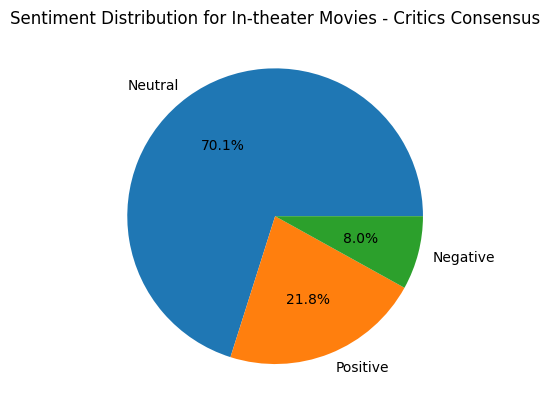

In [ ]:
# Create a pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution for In-theater Movies - Critics Consensus')
plt.show()

In [ ]:
movies_predict['runtime'] = pd.to_numeric(movies_predict['runtime'], errors='coerce')
movies_predict['tomatometer_rating'] = pd.to_numeric(movies_predict['tomatometer_rating'], errors='coerce')
movies_predict['audience_rating'] = pd.to_numeric(movies_predict['audience_rating'], errors='coerce')
movies_predict_data = movies_predict

In [ ]:
print(movies_predict_data.dtypes)

movie_title                   object
runtime                      float64
genres                        object
content_rating                object
critics_consensus             object
movie_info                    object
theater_link                  object
release_date                  object
tomatometer_rating           float64
audience_rating              float64
image                         object
link                          object
G                              int64
NC17                           int64
NR                             int64
PG                             int64
PG-13                          int64
R                              int64
Action & Adventure             int64
Comedy                         int64
Drama                          int64
Science Fiction & Fantasy      int64
Romance                        int64
Classics                       int64
Kids & Family                  int64
Mystery & Thriller             int64
Western                        int64
A

In [ ]:
import numpy as np

# Fill NaN values for the entire DataFrame where needed
movies_predict_data.fillna(0, inplace=True)

# Prepare features for prediction based on existing columns
feature_columns = ['G', 'NC17', 'NR', 'PG', 'PG-13', 'R',
                   'Action & Adventure', 'Comedy', 'Drama', 'Science Fiction & Fantasy',
                   'Romance', 'Classics', 'Kids & Family', 'Mystery & Thriller', 'Western',
                   'Art House & International', 'Horror', 'Faith & Spirituality',
                   'Animation', 'Documentary', 'Special Interest', 'Musical', 'Sports',
                   'Television', 'Cult Movies', 'Anime', 'LGBTQ+']

# Prediction logic
for index, row in movies_predict_data.iterrows():
    if row['tomatometer_rating'] == 0:
        if row['audience_rating'] > 0:
            # Features for lr_t, which includes audience_rating
            features = np.array(row[['runtime', 'Sentiment Score', 'audience_rating'] + feature_columns]).reshape(1, -1)
            row['tomatometer_rating'] = lr_t.predict(features)
        else:
            # Features for lr_tna, which does not include audience_rating
            features = np.array(row[['runtime', 'Sentiment Score'] + feature_columns]).reshape(1, -1)
            row['tomatometer_rating'] = lr_tna.predict(features)

    if row['audience_rating'] == 0:
        if row['tomatometer_rating'] > 0:
            # Features for lr_a, which includes tomatometer_rating
            features = np.array(row[['runtime', 'Sentiment Score', 'tomatometer_rating'] + feature_columns]).reshape(1, -1)
            row['audience_rating'] = lr_a.predict(features)
        else:
            # Assume lr_a is used here for cases where both ratings are missing
            features = np.array(row[['runtime', 'Sentiment Score'] + feature_columns]).reshape(1, -1)
            row['audience_rating'] = lr_ant.predict(features)

    # Update the DataFrame
    movies_predict_data.loc[index] = row

# Check the updated DataFrame
movies_predict_data[['movie_title', 'tomatometer_rating', 'audience_rating']]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

,movie_title,tomatometer_rating,audience_rating
0,The Fall Guy,83.000000,87.000000
1,Challengers,89.000000,74.000000
2,Unfrosted,40.000000,49.000000
3,The Idea of You,83.000000,55.778043
4,Civil War,81.000000,71.000000
...,...,...,...
82,Stay with Us,40.951178,34.451160
83,Household Saints,68.000000,74.000000
84,The Invisible Fight,58.000000,80.000000
85,Poppay Ki Wedding,38.507550,34.595994


In [ ]:
movies_predict_data.head(3)

,movie_title,runtime,genres,content_rating,critics_consensus,movie_info,theater_link,release_date,tomatometer_rating,audience_rating,...,Documentary,Special Interest,Musical,Sports,Television,Cult Movies,Anime,LGBTQ+,Sentiment Score,Sentiment Label
0,The Fall Guy,0.0,"Action, Comedy, Drama",PG-13,"With action, comedy, romance, and a pair of ma...","He's a stuntman, and like everyone in the stun...",https://www.fandango.com/the-fall-guy-2024-234...,"Opened May 03, 2024",83.0,87.0,...,0,0,0,0,0,0,0,0,0.8126,Positive
1,Challengers,0.0,Drama,,,"From visionary filmmaker Luca Guadagnino, Chal...",,"Opened Apr 26, 2024",89.0,74.0,...,0,0,0,0,0,0,0,0,0.0000,Neutral
2,Unfrosted,0.0,Comedy,PG-13,Much like a preservative-packed toaster pastry...,"Michigan, 1963. Kellogg's and Post, sworn cere...",https://www.netflix.com/watch/81481606?cmp=rt_...,"Opened May 03, 2024",40.0,49.0,...,0,0,0,0,0,0,0,0,0.2960,Positive


In [ ]:
movies_predict_data.columns

Index(['movie_title', 'runtime', 'genres', 'content_rating',
       'critics_consensus', 'movie_info', 'theater_link', 'release_date',
       'tomatometer_rating', 'audience_rating', 'image', 'link', 'G', 'NC17',
       'NR', 'PG', 'PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+',
       'Sentiment Score', 'Sentiment Label'],
      dtype='object')

In [ ]:
movies_predict.columns

Index(['movie_title', 'runtime', 'genres', 'content_rating',
       'critics_consensus', 'movie_info', 'theater_link', 'release_date',
       'tomatometer_rating', 'audience_rating', 'image', 'link', 'G', 'NC17',
       'NR', 'PG', 'PG-13', 'R', 'Action & Adventure', 'Comedy', 'Drama',
       'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family',
       'Mystery & Thriller', 'Western', 'Art House & International', 'Horror',
       'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest',
       'Musical', 'Sports', 'Television', 'Cult Movies', 'Anime', 'LGBTQ+',
       'Sentiment Score', 'Sentiment Label'],
      dtype='object')

In [ ]:
movies_final = movies_predict_data[['movie_title', 'tomatometer_rating', 'audience_rating']]

# Selecting columns from movie_predict
movies_info = movies_predict[['runtime', 'genres', 'content_rating', 'movie_info',
                              'critics_consensus', 'release_date', 'image', 'theater_link', 'link']]

# Joining the two dataframes on index
movies_final = movies_final.join(movies_info)
movies_final['runtime'].replace(0.0, pd.NA, inplace=True)
movies_final.replace("", pd.NA, inplace=True)
movies_final[['tomatometer_rating', 'audience_rating']] = movies_final[['tomatometer_rating', 'audience_rating']].astype(int)

movies_final = movies_final.rename(columns={'movie_title': 'Movie Title',
                                            'tomatometer_rating': 'Tomatometer Rating(Predicted)',
                                            'audience_rating': 'Audience Rating(Predicted)',
                                            'runtime': 'Runtime', 'genres': 'Genres',
                                            'content_rating': 'Content Rating',
                                            'movie_info': 'Movie Info',
                                            'critics_consensus': 'Critics Consensus',
                                            'image': 'Image Link',
                                            'theater_link': 'Theater Link',
                                            'link': 'Rotten Tomatoes Link',})

# Resetting index if needed
# movies_final.reset_index(drop=True, inplace=True)

movies_final.head(3)

,Movie Title,Tomatometer Rating(Predicted),Audience Rating(Predicted),Runtime,Genres,Content Rating,Movie Info,Critics Consensus,release_date,Image Link,Theater Link,Rotten Tomatoes Link
0,The Fall Guy,83,87,<NA>,"Action, Comedy, Drama",PG-13,"He's a stuntman, and like everyone in the stun...","With action, comedy, romance, and a pair of ma...","Opened May 03, 2024",https://resizing.flixster.com/X-k7-qm7k0NOJO2N...,https://www.fandango.com/the-fall-guy-2024-234...,https://www.rottentomatoes.com/m/the_fall_guy_...
1,Challengers,89,74,<NA>,Drama,<NA>,"From visionary filmmaker Luca Guadagnino, Chal...",<NA>,"Opened Apr 26, 2024",https://resizing.flixster.com/dMJO96IcJPA2EBIn...,<NA>,https://www.rottentomatoes.com/m/challengers_2024
2,Unfrosted,40,49,<NA>,Comedy,PG-13,"Michigan, 1963. Kellogg's and Post, sworn cere...",Much like a preservative-packed toaster pastry...,"Opened May 03, 2024",https://resizing.flixster.com/T4s5r7Dc85R3yDbD...,https://www.netflix.com/watch/81481606?cmp=rt_...,https://www.rottentomatoes.com/m/unfrosted


In [ ]:
movies_final.to_sql('movies', engine, if_exists='replace', index=False)

87

In [ ]:
movies_final = pd.read_sql("SELECT * FROM movies", con=engine)
movies_final.head(3)

,Movie Title,Tomatometer Rating(Predicted),Audience Rating(Predicted),Runtime,Genres,Content Rating,Movie Info,Critics Consensus,release_date,Image Link,Theater Link,Rotten Tomatoes Link
0,The Fall Guy,83,87,None,"Action, Comedy, Drama",PG-13,"He's a stuntman, and like everyone in the stun...","With action, comedy, romance, and a pair of ma...","Opened May 03, 2024",https://resizing.flixster.com/X-k7-qm7k0NOJO2N...,https://www.fandango.com/the-fall-guy-2024-234...,https://www.rottentomatoes.com/m/the_fall_guy_...
1,Challengers,89,74,None,Drama,None,"From visionary filmmaker Luca Guadagnino, Chal...",None,"Opened Apr 26, 2024",https://resizing.flixster.com/dMJO96IcJPA2EBIn...,None,https://www.rottentomatoes.com/m/challengers_2024
2,Unfrosted,40,49,None,Comedy,PG-13,"Michigan, 1963. Kellogg's and Post, sworn cere...",Much like a preservative-packed toaster pastry...,"Opened May 03, 2024",https://resizing.flixster.com/T4s5r7Dc85R3yDbD...,https://www.netflix.com/watch/81481606?cmp=rt_...,https://www.rottentomatoes.com/m/unfrosted


Similarity test

In [ ]:
import numpy as np
import pandas as pd
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

movies_final.columns

Index(['Movie Title', 'Tomatometer Rating(Predicted)',
       'Audience Rating(Predicted)', 'Runtime', 'Genres', 'Content Rating',
       'Movie Info', 'Critics Consensus', 'release_date', 'Image Link',
       'Theater Link', 'Rotten Tomatoes Link'],
      dtype='object')

In [ ]:
selected_features_new = ['Movie Title', 'Tomatometer Rating(Predicted)', 'Audience Rating(Predicted)', 'Runtime', 'Genres',
       'Content Rating', 'Movie Info', 'Critics Consensus',]
for feature_new in selected_features_new:
  movies_final[feature_new] = movies_final[feature_new].fillna('')

movies_final['Tomatometer Rating(Predicted)'] = movies_final['Tomatometer Rating(Predicted)'].astype(str)
movies_final['Audience Rating(Predicted)'] = movies_final['Audience Rating(Predicted)'].astype(str)
movies_final['Runtime'] = movies_final['Runtime'].astype(str)

combined_features_new = (
    movies_final['Movie Title'] + ' ' +
    movies_final['Tomatometer Rating(Predicted)'] + ' ' +
    movies_final['Audience Rating(Predicted)'] + ' ' +
    movies_final['Runtime'] + ' ' +
    movies_final['Genres'] + ' ' +
    movies_final['Content Rating'] + ' ' +
    movies_final['Movie Info'] + ' ' +
    movies_final['Critics Consensus']
)
print(combined_features_new)

0     The Fall Guy 83 87  Action, Comedy, Drama PG-1...
1     Challengers 89 74  Drama  From visionary filmm...
2     Unfrosted 40 49  Comedy PG-13 Michigan, 1963. ...
3     The Idea of You 83 55  Romance, Drama, Comedy ...
4     Civil War 81 71  Mystery & Thriller, Action, D...
                            ...                        
82    Stay with Us 40 34  Comedy  After three succes...
83    Household Saints 68 74  Comedy, Drama  Nancy S...
84    The Invisible Fight 58 80  Comedy, Action  USS...
85    Poppay Ki Wedding 38 34  Comedy, Romance  A mo...
86    The Heart Stays 50 40  Drama  A Native America...
Length: 87, dtype: object


In [ ]:
vectorizer = TfidfVectorizer()
feature_vectors_new = vectorizer.fit_transform(combined_features_new)
print(feature_vectors_new)

  (0, 999)	0.12354187542479925
  (0, 2617)	0.09517246850485857
  (0, 1767)	0.12354187542479925
  (0, 2310)	0.12354187542479925
  (0, 328)	0.06162115284860201
  (0, 1841)	0.11307157142182514
  (0, 2667)	0.0877436695908661
  (0, 1794)	0.11307157142182514
  (0, 1787)	0.12354187542479925
  (0, 2095)	0.12354187542479925
  (0, 2440)	0.0877436695908661
  (0, 3146)	0.07498906983300874
  (0, 2418)	0.0998805484055808
  (0, 1270)	0.0998805484055808
  (0, 2203)	0.11307157142182514
  (0, 684)	0.0998805484055808
  (0, 3106)	0.08198144548861422
  (0, 1587)	0.0877436695908661
  (0, 759)	0.09119184366740408
  (0, 888)	0.10564277250783267
  (0, 2687)	0.11307157142182514
  (0, 3111)	0.07727336558789198
  (0, 1706)	0.060473277339026715
  (0, 1391)	0.08744409986327085
  (0, 1749)	0.08198144548861422
  :	:
  (85, 1353)	0.07995234985464694
  (85, 622)	0.08670509447261333
  (85, 2822)	0.08224846314348923
  (86, 3092)	0.27136150677689264
  (86, 2389)	0.27136150677689264
  (86, 2899)	0.27136150677689264
  (86, 

In [ ]:
similarity_new = cosine_similarity(feature_vectors_new)
print(similarity_new)

[[1.         0.09485711 0.07317071 ... 0.06747974 0.09092537 0.0379342 ]
 [0.09485711 1.         0.04530092 ... 0.03202242 0.05018067 0.05803501]
 [0.07317071 0.04530092 1.         ... 0.02410969 0.03185306 0.03522918]
 ...
 [0.06747974 0.03202242 0.02410969 ... 1.         0.0393653  0.02601472]
 [0.09092537 0.05018067 0.03185306 ... 0.0393653  1.         0.03361692]
 [0.0379342  0.05803501 0.03522918 ... 0.02601472 0.03361692 1.        ]]


In [ ]:
movies_predict_data['genres']

0                 Action, Comedy, Drama
1                                 Drama
2                                Comedy
3                Romance, Drama, Comedy
4     Mystery & Thriller, Action, Drama
                    ...                
82                               Comedy
83                        Comedy, Drama
84                       Comedy, Action
85                      Comedy, Romance
86                                Drama
Name: genres, Length: 87, dtype: object

In [ ]:
unique_genres_string = "\n".join(flattened_genres_new.unique())
print(f'Here are the genres for the current in-theater movies: \n{unique_genres_string}')
movie_genre = input('\nEnter your favorite movie genre: ')

Here are the genres for the current in-theater movies: 
Action
Comedy
Drama
Romance
Mystery & Thriller
Horror
Sci-Fi
Adventure
Music
Fantasy
History
Kids & Family
Animation
Biography
LGBTQ+
Anime
Documentary
Crime
Musical

Enter your favorite movie genre: drama


In [ ]:
list_of_all_titles = movies_final['Genres'].values.tolist()
print(list_of_all_titles)

['Action, Comedy, Drama', 'Drama', 'Comedy', 'Romance, Drama, Comedy', 'Mystery & Thriller, Action, Drama', 'Horror, Mystery & Thriller', 'Horror, Mystery & Thriller', 'Action, Mystery & Thriller', 'Horror, Mystery & Thriller', 'Horror, Mystery & Thriller', 'Action, Comedy', 'Sci-Fi, Action, Adventure', 'Drama, Music', 'Sci-Fi, Action, Adventure', 'Sci-Fi, Adventure, Action, Fantasy, Drama', 'Action, Comedy, Mystery & Thriller', 'Horror, Mystery & Thriller', 'Drama, Adventure', 'Sci-Fi, Adventure, Action, Fantasy', 'Sci-Fi, Horror', 'Comedy, Fantasy, Adventure', 'Horror', 'History, Drama', 'Kids & Family, Comedy, Adventure, Animation, Action', 'History, Drama, Romance, Biography', 'Horror, Mystery & Thriller', 'Sci-Fi, Mystery & Thriller', 'History, Drama, Biography', 'Mystery & Thriller, Drama, LGBTQ+', 'Comedy, Mystery & Thriller', 'Horror, Mystery & Thriller', 'Adventure, Comedy, Anime, Action', 'Action, Mystery & Thriller', 'Comedy, History, Mystery & Thriller', 'Mystery & Thriller

In [ ]:
find_close_match = difflib.get_close_matches(movie_genre, list_of_all_titles, cutoff=0.1)
print(find_close_match)

['Drama', 'Drama', 'Drama']


In [ ]:
#Option 1
find_close_match = difflib.get_close_matches(movie_genre, list_of_all_titles, cutoff=0.1)
print('Movies suggested for you:\n')
# Iterate through the close matches
for i, movie_title in enumerate(find_close_match, start=1):
    # Find the index of the matched movie
    index = movies_final[movies_final['Genres'] == movie_title].index
    if not index.empty:
        index = index[0]
        # Get movie details
        title_from_index = movies_final.loc[index, 'Movie Title']
        m_genre = movies_final.loc[index, 'Genres']
        rt_link = movies_final.loc[index, 'Rotten Tomatoes Link']
        t_link = movies_final.loc[index, 'Theater Link']
        m_info = movies_final.loc[index, 'Movie Info']
        # Print movie details
        print(f"{i}. {title_from_index} ({m_genre}. Rotten Tomatoes: {rt_link} Theater: {t_link})")
        print(m_info + "\n")
    else:
        print("Sorry, no movies found with the close match genre.")

Movies suggested for you:

1. Challengers (Drama. Rotten Tomatoes: https://www.rottentomatoes.com/m/challengers_2024 Theater: None)
From visionary filmmaker Luca Guadagnino, Challengers stars Zendaya as Tashi Duncan, a former tennis prodigy turned coach and a force of nature who makes no apologies for her game on and off the court. Married to a champion on a losing streak (Mike Faist - West Side Story), Tashi's strategy for her husband's redemption takes a surprising turn when he must face off against the washed-up Patrick (Josh O'Connor - The Crown) -- his former best friend and Tashi's former boyfriend. As their pasts and presents collide, and tensions run high, Tashi must ask herself, what will it cost to win.

2. Challengers (Drama. Rotten Tomatoes: https://www.rottentomatoes.com/m/challengers_2024 Theater: None)
From visionary filmmaker Luca Guadagnino, Challengers stars Zendaya as Tashi Duncan, a former tennis prodigy turned coach and a force of nature who makes no apologies for 

In [ ]:
#Option 2 (Search for the similar movies based on the first movies)
close_match = find_close_match[0]
filtered_movies = movies_final[movies_final['Genres'] == close_match]

if not filtered_movies.empty:
    # Retrieve the index of the first movie
    index_of_the_movie = filtered_movies.index[0]
    #print(index_of_the_movie)
    similarity_score_new = list(enumerate(similarity_new[index_of_the_movie]))
    #print(similarity_score_new)
    sorted_similar_movies_new = sorted(similarity_score_new, key = lambda x:x[1], reverse = True)
    #print(sorted_similar_movies_new)
    print('Movies suggested for you:\n')

    # Assuming sorted_similar_movies_new contains the sorted list of similar movies
    i = 1
    for movie in sorted_similar_movies_new:
        index = movie[0]
        title_from_index = movies_final.loc[index, 'Movie Title']
        # Get the Rotten Tomatoes link for the current movie
        m_genre = movies_final.loc[index, 'Genres']
        rt_link = movies_final.loc[index, 'Rotten Tomatoes Link']
        t_link = movies_final.loc[index, 'Theater Link']
        m_info = movies_final.loc[index, 'Movie Info']
        print(f"{i}. {title_from_index} ({m_genre}. Rotten Tomatoes: {rt_link} Theater: {t_link})")
        print(m_info+"\n")
        i += 1
        if i > 3:
            break

else:
    print("Sorry, No movies found with the close match genre.")

Movies suggested for you:

1. Challengers (Drama. Rotten Tomatoes: https://www.rottentomatoes.com/m/challengers_2024 Theater: None)
From visionary filmmaker Luca Guadagnino, Challengers stars Zendaya as Tashi Duncan, a former tennis prodigy turned coach and a force of nature who makes no apologies for her game on and off the court. Married to a champion on a losing streak (Mike Faist - West Side Story), Tashi's strategy for her husband's redemption takes a surprising turn when he must face off against the washed-up Patrick (Josh O'Connor - The Crown) -- his former best friend and Tashi's former boyfriend. As their pasts and presents collide, and tensions run high, Tashi must ask herself, what will it cost to win.

2. Chief of Station (Action, Mystery & Thriller. Rotten Tomatoes: https://www.rottentomatoes.com/m/chief_of_station Theater: None)
Ben is a former CIA station chief whose world comes crashing down after his wife, a former operative, dies in a terrible accident. Soon, a crypti

Gemini in the other doc